In [2]:
import pandas as pd
from pyarrow import feather
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import umap

c:\Users\hanse\Documents\census_ml\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%%time
d = feather.read_feather("census_features_2019.feather")
print(d.shape)
d.head()

(87043040, 3)
CPU times: total: 11 s
Wall time: 8.7 s


,value,unique_id,variable
0,20245.0,17051,B01001A_001E
1,25667.0,17107,B01001A_001E
2,22234.0,17165,B01001A_001E
3,531609.0,17097,B01001A_001E
4,12956.0,17127,B01001A_001E


In [70]:
acs_vars = pd.read_csv("acs_vars.csv")
states =  pd.read_csv("state-geocodes.csv")
states.columns = [c.lower().replace(" ", "_").replace(r"(fips)", "fips") for c in states.columns]
for col in states.columns: states[col] = states[col].astype(str)

In [71]:
def parse_fips(f):
    f = str(f)
    if len(f) < 2:
        return "0"+f
    return f
states.state_fips = states.state_fips.apply(parse_fips)

In [40]:
fips_ids = d.unique_id.unique()
n_counties = len(fips_ids)
tot_n_variables  = d.variable.nunique()

print(n_counties, tot_n_variables)

3220 27032


In [41]:
%%time
# deal with missing values
## simple: get rid of any variable which is not complete for all counties

var_groups = d.groupby("variable")
complete_vars = []
for name, var in var_groups:
    var.dropna(axis=0, inplace=True)
    if var.shape[0] != n_counties:
        continue
    complete_vars.append(name)

CPU times: total: 43.4 s
Wall time: 46 s


In [54]:
print(f"N variables with values for all counties:", len(complete_vars))

N variables with values for all counties: 15910


In [55]:
d_complete = d.loc[d.variable.isin(complete_vars), :].reset_index(drop=True)
n_variables = d_complete.variable.nunique()

In [56]:
%%time
# Build feature vectors per-fips
fips_groups = d_complete.groupby("unique_id")
feature_array = np.zeros((len(fips_ids), n_variables), dtype=np.float32)

for i, (name, group) in enumerate(fips_groups):
    feature_array[i,:] = group["value"].values

CPU times: total: 16 s
Wall time: 16.1 s


In [57]:
features_scaled = StandardScaler().fit_transform(feature_array)

https://pair-code.github.io/understanding-umap/

In [58]:
%%time
# api: https://umap-learn.readthedocs.io/en/latest/api.html
reducer = umap.UMAP(
    n_neighbors=10, #default: 15
    n_components=2,  
    min_dist=0.1,   #default: 0.1
    n_epochs=1000,   #1000
    verbose=True
)
x = reducer.fit_transform(features_scaled)

UMAP(n_epochs=1000, n_neighbors=10, verbose=True)
Wed Feb  8 02:13:12 2023 Construct fuzzy simplicial set
Wed Feb  8 02:13:43 2023 Finding Nearest Neighbors
Wed Feb  8 02:13:46 2023 Finished Nearest Neighbor Search
Wed Feb  8 02:13:48 2023 Construct embedding


Epochs completed: 100%| ██████████ 1000/1000 [00:05]


Wed Feb  8 02:13:54 2023 Finished embedding
CPU times: total: 1min 9s
Wall time: 42.6 s


In [72]:
plot_df = pd.DataFrame({"fips" : fips_ids})
plot_df["x"] = x[:, 0]
plot_df["y"] = x[:, 1]
plot_df["state"] = plot_df.fips.str.slice(0, 2)
plot_df = plot_df.merge(states, how="left", left_on="state", right_on="state_fips")

In [86]:
plot_df["region_name"] = plot_df.region.map({"1" : "Northeast", "2" : "Midwest", "3" : "South", "4" : "West"})

In [84]:
states.loc[states.region=="5", ]

,region,division,state_fips,name


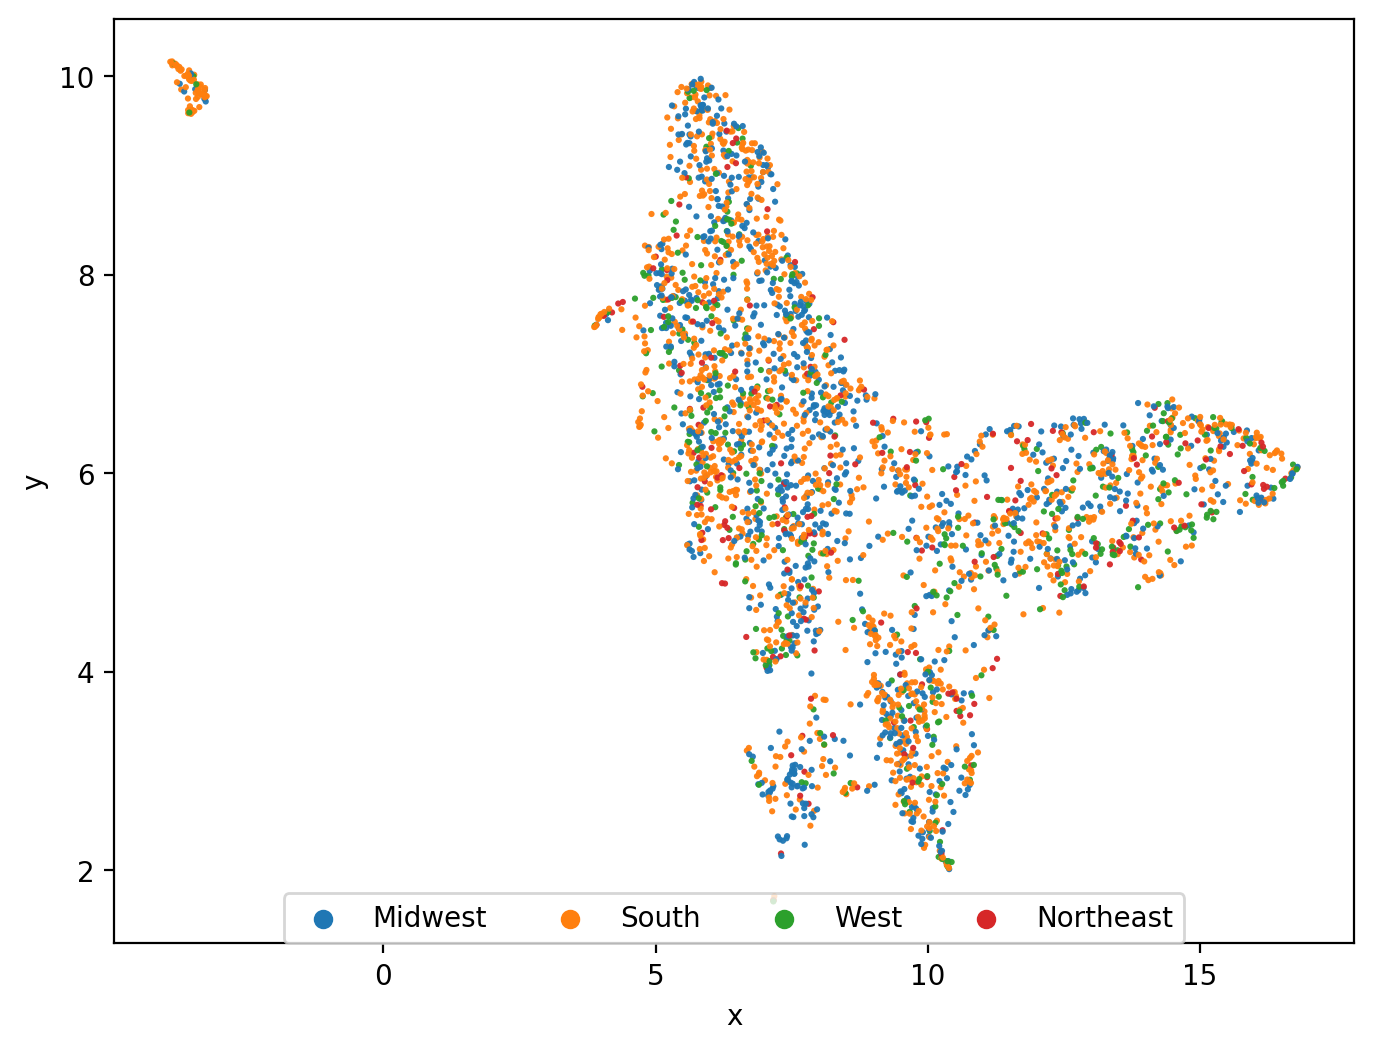

In [87]:
plt.figure(figsize=(8,6), dpi=200)
# plt.xlim(-20,20)
# plt.ylim(-20,20)

ax = sns.scatterplot(
    x='x',
    y='y',
    s=5,
    linewidth=0,
    alpha=0.95,
    hue='region_name',
    palette='tab10',
    legend=True,
    data=plot_df,
)
plt.legend(loc="lower center", ncol=plot_df.state.nunique() // 4, borderaxespad=0)
plt.show()